# Notatki do pracowni drugiej

Rozwiązujemy układ równań

\begin{equation}
(x-x_1)^2 + (y-y_1)^2 + (z-z_1)^2 = \big[c(t_1-t)\big]^2 \\
(x-x_2)^2 + (y-y_2)^2 + (z-z_2)^2 = \big[c(t_2-t)\big]^2 \\
(x-x_3)^2 + (y-y_3)^2 + (z-z_3)^2 = \big[c(t_3-t)\big]^2 \\
(x-x_4)^2 + (y-y_4)^2 + (z-z_4)^2 = \big[c(t_4-t)\big]^2 \\
\end{equation}

Niech
\begin{equation}
f_i(x, y, z, t) = (x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2 - \big[c(t_i-t)\big]^2
\end{equation}

## Metoda Newtona

Z uogólnionego twierdzenia Taylora mamy
\begin{equation}
f_i(x + h_x, y + h_y, z + h_z, t + h_t) \approx f_i(x, y, z, t) + h_x \frac{\partial f_i}{\partial x}(x, y, z, t) 
+ h_y \frac{\partial f_i}{\partial y}(x, y, z, t) + h_z \frac{\partial f_i}{\partial z}(x, y, z, t)
+ h_t \frac{\partial f_i}{\partial t}(x, y, z, t)
\end{equation}

Ponadto
\begin{equation}
\frac{\partial f_i}{\partial x} = 2(x-x_i) \\
\frac{\partial f_i}{\partial y} = 2(y-y_i) \\
\frac{\partial f_i}{\partial z} = 2(z-z_i) \\
\frac{\partial f_i}{\partial t} = -2c^2(t-t_i)
\end{equation}

Stąd
\begin{equation}
f_i(x + h_x, y + h_y, z + h_z, t + h_t) \approx f_i(x, y, z, t) + 2h_x(x-x_i) + 2h_y(y-y_i) + 2h_z(z-z_i) -2c^2h_t(t-t_i)
\end{equation}

Zastosujemy metodę Newtona. Chcemy znaleźć $x, y, z, t$, dla których $f_i(x, y, z, t) = 0$ dla $1 \leq i \leq 4$.
Niech $x_n \in \mathbb{R}^4$ będzie n-tym przybliżeniem metody Newtona. Szukamy $h \in \mathbb{R}^4$, takiego że
dla $x_{n+1} = x_n + h$ zajdzie $f_i(x_{n+1}) = 0$ dla $1 \leq i \leq 4$.

Niech
$$
x_n = 
    \begin{pmatrix}
    x \\
    y \\
    z \\
    t
    \end{pmatrix}
$$

Rozwiążemy układ równań
\begin{equation}
0 = f_1(x, y, z, t) + 2h_x(x-x_1) + 2h_y(y-y_1) + 2h_z(z-z_1) -2c^2h_t(t-t_1) \\
0 = f_2(x, y, z, t) + 2h_x(x-x_2) + 2h_y(y-y_2) + 2h_z(z-z_2) -2c^2h_t(t-t_2) \\
0 = f_3(x, y, z, t) + 2h_x(x-x_3) + 2h_y(y-y_3) + 2h_z(z-z_3) -2c^2h_t(t-t_3) \\
0 = f_4(x, y, z, t) + 2h_x(x-x_4) + 2h_y(y-y_4) + 2h_z(z-z_4) -2c^2h_t(t-t_4)
\end{equation}
Inaczej
\begin{equation}
\begin{pmatrix}
x-x_1  & y-y_1 & z-z_1 & -c^2(t-t_1) \\
x-x_2  & y-y_2 & z-z_2 & -c^2(t-t_2) \\
x-x_3  & y-y_3 & z-z_3 & -c^2(t-t_3) \\
x-x_4  & y-y_4 & z-z_4 & -c^2(t-t_4) \\
\end{pmatrix}
\begin{pmatrix}
h_x \\ h_y \\ h_z \\ h_t
\end{pmatrix}
=
-\frac{1}{2}
\begin{pmatrix}
f_1(x, y, z, t) \\
f_2(x, y, z, t) \\
f_3(x, y, z, t) \\
f_4(x, y, z, t)
\end{pmatrix}
\end{equation}

Wtedy 
$$
x_{n+1} = x_n + h = x_n + \begin{pmatrix} h_x \\ h_y \\ h_z \\ h_t \end{pmatrix}
$$

In [85]:
c = 299792.458;

In [86]:
function product(a, b)
    a[1]*b[1] + a[2]*b[2] + a[3]*b[3] - a[4]*b[4]
end

function f(x, A)
    [ product(x-A[i, :], x-A[i, :]) for i=1:size(A, 1) ]
end

function jacobian(x, A)
    i = vcat(ones(size(A, 2) - 1), -1)
    hcat([ i .* (x - A[j, :]) for j = 1:size(A, 1) ]...)'
end

function newton(sats, maxiter=20)
    A = hcat(sats...)'
    A[:, 4] *= c
    x = zeros(4)
    for i = 1:maxiter
        J = jacobian(x, A)
        b = -0.5 * f(x, A)
        x += pinv(J) * b
    end
    x[4] /= c
    x
end;

# Metoda najmniejszych kwadratów

Mamy układ równań
$$ (x-x_{i})^2 + (y - y_{i})^2 + (z - z_{i})^2 - \big[c(t_{i}-t)\big]^2 = 0 \ , \ i =  1, 2 \ ... \ n \ , \ n > 4$$
Niech
$$ f_{i}(x, y, z, t) = (x-x_{i})^2 + (y - y_{i})^2 + (z - z_{i})^2 - \big[c(t_{i}-t)\big]^2 $$
Chcemy znaleźć takie $(x, y, z, t)$, że
$$\sum_{1}^{n} f_{i}^2(x, y, z, t) $$ 
będzie minimalne.

Zastosujemy metodę będącą uogólnieniem metody Newtona opisanej powyżej:
Niech:
$$ h_{n} = -(J_{n}^T J_{n})^{-1} J^T F(x_{n})$$
gdzie

$J_{n}$ - macierz pochodnych cząstkowych w punkcie $x_n$ 

$J_{n}[i, j] = \frac{\partial f_i}{\partial x_j} $

$F(x) \in R^4 \to R^n , F(x) = \big[f_{i}(x)\big]$

Wtedy
$$ x_{n+1} = x_{n} + h_{n} $$
Jest n-tym przybliżeniem metody.

In [96]:
function leastSquares(sats, maxiter=20, satcnt=8)
    newton(sats[1:satcnt], maxiter)
end;

## Metoda algebraiczna

Zastosujemy inne podejście (nieiteracyjne). Rozważany układ równań wygląda następująco

$$
x^2 + y^2 + z^2 -2xx_1 -2yy_1 -2zz_1 + x_1^2 + y_1^2 + z_1^2 = c^2(t^2 -2tt_1 + t_1^2) \\
x^2 + y^2 + z^2 -2xx_2 -2yy_2 -2zz_2 + x_2^2 + y_2^2 + z_2^2 = c^2(t^2 -2tt_2 + t_2^2) \\
x^2 + y^2 + z^2 -2xx_3 -2yy_3 -2zz_3 + x_3^2 + y_3^2 + z_3^2 = c^2(t^2 -2tt_3 + t_3^2) \\
x^2 + y^2 + z^2 -2xx_4 -2yy_4 -2zz_4 + x_4^2 + y_4^2 + z_4^2 = c^2(t^2 -2tt_4 + t_4^2)
$$

Po odjęciu czwartego równania stronami od pierwszych trzech otrzymamy

$$
-2x(x_1-x_4) -2y(y_1-y_4) -2z(z_1-z_4) + x_1^2 + y_1^2 + z_1^2 - (x_4^2 + y_4^2 + z_4^2) = c^2(-2t(t_1-t_4)+t_1^2-t_4^2) \\
-2x(x_2-x_4) -2y(y_2-y_4) -2z(z_2-z_4) + x_2^2 + y_2^2 + z_2^2 - (x_4^2 + y_4^2 + z_4^2) = c^2(-2t(t_2-t_4)+t_2^2-t_4^2) \\ 
-2x(x_3-x_4) -2y(y_3-y_4) -2z(z_3-z_4) + x_3^2 + y_3^2 + z_3^2 - (x_4^2 + y_4^2 + z_4^2) = c^2(-2t(t_3-t_4)+t_3^2-t_4^2)
$$

Otrzymaliśmy więc układ 3 równań liniowych na 4 zmiennych. Układ taki nie posiada jednozanczego rozwiązania, ale - o ile nie jest sprzeczny - posiada rozwiązania parametryczne. W naszym przypadku (dla realnych danych) powinno to być rozwiązanie zależne od jednego parametru. Oznacza to, że pozostałe zmienne można wyrazić jako kombinacje liniowe tego parametru tak, aby dla dowolnej wartości parametru układ równań był spełniony. Ponieważ dla faktycznych danych żadna zmienna nie powinna być z góry ustalona (na trzech równaniach), to możemy założyć, że parametrem jest $t$. Wtedy dla pewnych rzeczywistych $a_x, a_y, a_z, b_x, b_y, b_z$ mamy

$$ 
x = a_xt + b_x \\
y = a_yt + b_y \\
z = a_zt + b_z
$$
Wówczas dla dowolnego $t$ zachodzi

$$
-2(a_xt+b_x)(x_1-x_4)-2(a_yt+b_y)(y_1-y_4)-2(a_xt+b_z)(z_1-z_4)+x_1^2+y_1^2+z_1^2-c_0=c^2(-2t(t_1-t_4)+t_1^2-t_4^2) \\
-2(a_xt+b_x)(x_2-x_4)-2(a_yt+b_y)(y_2-y_4)-2(a_xt+b_z)(z_2-z_4)+x_2^2+y_2^2+z_2^2-c_0=c^2(-2t(t_2-t_4)+t_2^2-t_4^2) \\
-2(a_xt+b_x)(x_3-x_4)-2(a_yt+b_y)(y_3-y_4)-2(a_xt+b_z)(z_3-z_4)+x_3^2+y_3^2+z_3^2-c_0=c^2(-2t(t_3-t_4)+t_3^2-t_4^2)
$$

gdzie $c_0 = x_4^2 + y_4^2 + z_4^2$.

Otrzymaliśmy zatem równości trzech funckji liniowych dla każdego argumentu. 

Stąd
$$
a_x(x_1-x_4) + a_y(y_1-y_4) + a_z(z_1-z_4) = c^2(t_1-t_4) \\
a_x(x_2-x_4) + a_y(y_2-y_4) + a_z(z_2-z_4) = c^2(t_2-t_4) \\
a_x(x_3-x_4) + a_y(y_3-y_4) + a_z(z_3-z_4) = c^2(t_3-t_4) \\
-2(b_x(x_1-x_4)+b_y(y_1-y_4)+b_z(z_1-z_4)) + x_1^2+y_1^2+z_1^2 - c_0 = c^2(t_1^2 - t_4^2) \\
-2(b_x(x_2-x_4)+b_y(y_2-y_4)+b_z(z_2-z_4)) + x_2^2+y_2^2+z_2^2 - c_0 = c^2(t_2^2 - t_4^2) \\
-2(b_x(x_3-x_4)+b_y(y_3-y_4)+b_z(z_3-z_4)) + x_3^2+y_3^2+z_3^2 - c_0 = c^2(t_3^2 - t_4^2)
$$

Inaczej
$$
\begin{pmatrix}
x_1-x_4 & y_1-y_4 & z_1-z_4 \\
x_2-x_4 & y_2-y_4 & z_2-z_4 \\
x_3-x_4 & y_3-y_4 & z_3-z_4
\end{pmatrix}
\begin{pmatrix}
a_x \\ a_y \\ a_z
\end{pmatrix}
=
c^2
\begin{pmatrix}
t_1-t_4 \\ t_2-t_4 \\ t_3-t_4
\end{pmatrix}
\\
\begin{pmatrix}
x_1-x_4 & y_1-y_4 & z_1-z_4 \\
x_2-x_4 & y_2-y_4 & z_2-z_4 \\
x_3-x_4 & y_3-y_4 & z_3-z_4
\end{pmatrix}
\begin{pmatrix}
b_x \\ b_y \\ b_z
\end{pmatrix}
=
-\frac{1}{2}
\begin{pmatrix}
c^2(t_1^2-t_4^2) - x_1^2+y_1^2+z_1^2 + c_0 \\
c^2(t_2^2-t_4^2) - x_2^2+y_2^2+z_1^2 + c_0 \\
c^2(t_3^2-t_4^2) - x_3^2+y_3^2+z_1^2 + c_0 
\end{pmatrix}
$$

Z ostatnich dwóch równości możemy łatwo wyznaczyć współczynniki $a_x, a_y, a_z, b_x, b_y, b_z$.

Aby otrzymać konkretne rozwiązanie, możemy podstawić otrzymane zależności do czwartego równania. Wtedy otrzymamy równanie kwadratowe jednej zmiennej następującej postaci

$$
  t^2(a_x^2+a_y^2+a_x^2-c^2) + 2t(a_x(b_x-x_4)+a_y(b_y-y_4)+a_z(b_z-z_4)-c^2t_4^2) + (b_x-x_4)^2+(b_y-y_4)^2+(b_z-z_4)-c^2t_4^2 = 0
$$

Po rozwiązaniu równania otrzymamy dwa kandydaty (?) na $t$, które wyznaczą dwa możliwe rozwiązania $x, y, z, t$. W poniższym kodzie przyjęto, że szukanym rozwiązaniem jest to o mniejszym bezwzględnym błędzie zegara.

In [97]:
using Polynomials

function algebraic(sats)
    x = [sat[1:3] for sat in sats]
    t = c * [sat[4] for sat in sats]
    
    last = length(sats)
    A = hcat([x[i] - x[last] for i = 1:(last-1)]...)'
    B = t[1:(last-1)] .- t[last]
    c0 = sum(abs2, x[last])
    C = -0.5 * [ t[i]^2 - t[last]^2 - sum(abs2, x[i]) + c0 for i = 1:(last-1)]
    
    invA = pinv(A)
    a = invA * B
    b = invA * C
    bdiff = b - x[last]
    
    coeffs = Array{Float64}(3)
    coeffs[1] = sum(abs2, bdiff) - t[last]^2
    coeffs[2] = 2*(sum(a .* bdiff) + t[last])
    coeffs[3] = sum(abs2, a) - 1
    rts = filter(x -> isreal(x), roots(Poly(coeffs)))
    if(length(rts) < 2)
        push!(rts, 0)
    end
    
#     guess = rts[indmin(abs.(rts))]
#     vcat([a[i]*guess + b[i] for i = 1:3], guess / c)
    
    loc1 = vcat([a[i]*rts[1] + b[i] for i = 1:3], rts[1])
    loc2 = vcat([a[i]*rts[2] + b[i] for i = 1:3], rts[2])
    M = hcat(sats...)'
    M[:, 4] *= c
    if(norm(vcat(f(loc1, M), loc1)) < norm(vcat(f(loc2, M), loc2)))
        location = loc1
    else
        location = loc2
    end
    location[4] /= c
    location
end; 

## Metoda Bancrofta

In [98]:
function bancroft(sats)
    A = hcat(sats...)'
    A[:, 4] *= c
    i = ones(length(sats))
    r = 0.5 * [product(A[i, :], A[i, :]) for i=1:size(A, 1)]
    B = pinv(A)
    
    u = B * i
    v = B * r
    E = product(u, u)
    F = product(u, v) - 1
    G = product(v, v)
    rts = filter(x -> isreal(x), roots(Poly([G, 2*F, E])))
    if(length(rts) < 2)
        push!(rts, 0)
    end
    
    j = [1, 1, 1, -1]
    loc1 = j .* (rts[1] * u + v)
    loc2 = j .* (rts[2] * u + v)
    if(norm(vcat(f(loc1, A), loc1)) < norm(vcat(f(loc2, A), loc2)))
        location = loc1
    else
        location = loc2
    end
    location[4] /= c
    location
end;

## Heura

Rozwiążemy taki układ równań w sensie najmniejszych kwadratów

$$
-2x(x_i-x_4) -2y(y_i-y_4) -2z(z_i-z_4) + x_i^2 + y_i^2 + z_i^2 - (x_4^2 + y_4^2 + z_4^2) = c^2(-2t(t_i-t_4)+t_i^2-t_4^2) \\
$$

Inaczej
$$
\begin{pmatrix}
x_1-x_4 & y_1-y_4 & z_1-z_4 & t_4-t_1 \\
x_2-x_4 & y_2-y_4 & z_2-z_4 & t_4-t_2 \\
x_3-x_4 & y_3-y_4 & z_3-z_4 & t_4-t_3
\end{pmatrix}
\begin{pmatrix}
x \\ y \\ z \\ t
\end{pmatrix}
=
-\frac{1}{2}
\begin{pmatrix}
-(x_1^2+y_1^2+z_1^2-t_1^2)+c_1 \\
-(x_2^2+y_2^2+z_2^2-t_2^2)+c_1 \\
-(x_3^2+y_3^2+z_3^2-t_3^2)+c_1 \\
\end{pmatrix}
$$
gdzie $c_1=x_4^2+y_4^2+z_4^2-t_4^2$.

In [99]:
function heura(sats)
    j = [1, 1, 1, -1]
    last = length(sats)
    for i=1:last
        sats[i][4] *= c
    end
    
    A = hcat([j .* (sats[i] - sats[last]) for i = 1:(last-1)]...)'
    c1 = product(sats[last], sats[last])
    b = -0.5 * [ c1 - product(sats[i], sats[i]) for i = 1:(last-1) ]
    
    x = pinv(A) * b
    x[4] /= c
    
    for i=1:last
        sats[i][4] /= c
    end
    x
end; 

# Testy

In [135]:
earth_rad = 6370.0
sat_rad = 20e3

function randSgn()
    x = rand(0:1)
    if x==0
        return -1
    else
        return 1
    end
end

function rand_position(radius) 
    x = randSgn() * rand() * radius
    y = randSgn() * rand() * (radius - abs(x))
    z = randSgn() * sqrt(radius^2 - x^2 - y^2)
    t = randSgn() * rand() / 10
    [x, y, z, t]
end

function prepsat!(x, sat)
    for i = 1:length(sat)
        sat[i][4] = norm(x[1:3]-sat[i][1:3]) / c + x[4]
    end
end

sat = Array{Array{Float64}}(7)

sat[1] = [15600.0, 7540.0, 20140.0, 7.074e-2]
sat[2] = [18760.0, 2750.0, 18610.0, 7.220e-2]
sat[3] = [17610.0, 14630.0, 13480.0, 7.690e-2]
sat[4] = [19170.0, 610.0, 18390.0, 7.242e-2]
sat[5] = rand_position(sat_rad)
sat[6] = rand_position(sat_rad)
sat[7] = rand_position(sat_rad)

x = rand_position(earth_rad)
prepsat!(x, sat)

println(x)
println(newton(sat))
println(algebraic(sat))
println(bancroft(sat))
println(heura(sat))

[-2465.82, -196.753, 5870.09, 0.0389494]
[-2465.82, -196.753, 5870.09, 0.0389494]
[-2465.82, -196.753, 5870.09, 0.0389494]
[-2465.82, -196.753, 5870.09, 0.0389494]
[-2465.82, -196.753, 5870.09, 0.0389494]


In [101]:
function table(arr::Matrix; pre=true, column_names=nothing)
    if column_names !== nothing
        arr = vcat(reshape(column_names, 1, length(column_names)), arr)
    end
    s =
    """
    <table border="1">
    """
    for r in 1:size(arr, 1)
        s *= "<tr>"
        for c in 1:size(arr, 2)
            s *= "<td>"
            if pre s *= "<pre>" end
            s *= string(arr[r, c])
            if pre s *= "</pre>" end
        end
        s *= "</tr>"
    end
    s *= "</table>"
    return HTML(s)
end;

Będziemy sprawdzać dokładność metod za pomocą symulacji trasy obiektu na powierzchni Ziemi oraz pozycji satelit. Znając rzeczywiste położenie satelity, obiektu i błędu zegara wyliczamy stałe $t_{i}$. Następnie stosujemy każdą z metod do wyliczenia położenia obiektu.

Aby wzbogacić symulację, dodany został współczynnik $inacuraccy$ mający na celu odwzorować zmiany prędkości światła ośrodkach innych niż próżnia.

In [102]:
using PyPlot

In [103]:
function path(maxiter, lon0, lat0)
    a = pi/4
    d = 0.00000005
    lon = lon0 + d*cos(a)
    lat = lat0 + d*sin(a)
    t=0
    res = [[], []]
    for i in 1:maxiter
        push!(res[1], lon)
        push!(res[2], lat)
        if t==0
            t = rand(20:50)
            da = rand()*randSgn()
            a +=da
        end
        lon += d*cos(a)
        lat += d*sin(a)
        t-=1
    end
    res
end

function LLAtoXYZ(LL)
    rad = 6378.1
    lon = LL[1]
    lat = LL[2]
    cosLat = cos(lat * pi / 180.0)
    sinLat = sin(lat * pi / 180.0)
    cosLon = cos(lon * pi / 180.0)
    sinLon = sin(lon * pi / 180.0)
    x = rad * cosLat * cosLon
    y = rad * cosLat * sinLon
    z = rad * sinLat
    [x, y, z]
end

function XYZtoLLA(X)
    rad = 6378.1
    x = X[1]
    y = X[2]
    z = X[3]
    lat = asin(z / rad) * 180 / pi
    lon = atan(y / x) * 180 / pi
    return [lon, lat]
end

function inaccuracy(inaccurate)
    if inaccurate 
        return (1 + rand()/500000000)
    end
    return 1
end

function countTime(mistake, Pos, sat, inaccurate=false)
    C = 299792.458
    dist = norm(Pos[1:3]-sat[1:3])
    t = dist / C
    return [t + mistake]*inaccuracy(inaccurate)
end

sat_count = 8
sat_coords = [ rand_position(sat_rad)[1:3] for i = 1:sat_count ]
# sat_coords[1] = [15600,7540,20140]
# sat_coords[2] = [18760,2750,18610]
# sat_coords[3] = [17610,14630,13480]
# sat_coords[4] = [19170,610,18390]

function createSats(lon, lat, mistake, inaccuracy=false)
    [ vcat(sat_pos, countTime(mistake, LLAtoXYZ([lon, lat]), sat_pos, inaccuracy) ) for sat_pos in sat_coords ]
#     sat = Array{Array{Float64}}(5)
#     sat[1] = vcat(sat1, countTime(mistake, LLAtoXYZ([lon, lat]), sat1) )
#     sat[2] = vcat(sat2, countTime(mistake, LLAtoXYZ([lon, lat]), sat2) )
#     sat[3] = vcat(sat3, countTime(mistake, LLAtoXYZ([lon, lat]), sat3) )
#     sat[4] = vcat(sat4, countTime(mistake, LLAtoXYZ([lon, lat]), sat4) )
#     sat[5] = vcat(sat5, countTime(mistake, LLAtoXYZ([lon, lat]), sat5) )
#     sat
end

function GPS_newton(coords, mistake, maxiter=20, inaccuracy=false)
    res = [[],[]]
    for i in 1:length(coords[1])
        sat = createSats(coords[1][i], coords[2][i], mistake, inaccuracy)
        X = newton(sat[1:4], maxiter)
        LL = XYZtoLLA(X[1:3])
        push!(res[1], LL[1])
        push!(res[2], LL[2])
    end
    return res
end

function GPS_leastSquares(coords, mistake, maxiter=20, satcnt=sat_count, inaccuracy=false) 
    res = [[],[]]
    for i in 1:length(coords[1])
        sat = createSats(coords[1][i], coords[2][i], mistake, inaccuracy)
        X = leastSquares(sat, maxiter, satcnt)
        LL = XYZtoLLA(X[1:3])
        push!(res[1], LL[1])
        push!(res[2], LL[2])
    end
    return res
end

function GPS_alg(coords, mistake, inaccuracy=false)
    res = [[],[]]
    for i in 1:length(coords[1])
        sat = createSats(coords[1][i], coords[2][i], mistake, inaccuracy)
        X = algebraic(sat)
        LL = XYZtoLLA(X[1:3])
        push!(res[1], LL[1])
        push!(res[2], LL[2])
    end
    return res
end

function GPS_bancroft(coords, mistake, inaccuracy=false)
    res = [[],[]]
    for i in 1:length(coords[1])
        sat = createSats(coords[1][i], coords[2][i], mistake, inaccuracy)
        X = bancroft(sat)
        LL = XYZtoLLA(X[1:3])
        push!(res[1], LL[1])
        push!(res[2], LL[2])
    end
    return res
end

function GPS_heura(coords, mistake, inaccuracy=false) 
    res = [[],[]]
    for i in 1:length(coords[1])
        sat = createSats(coords[1][i], coords[2][i], mistake, inaccuracy)
        X = heura(sat)
        LL = XYZtoLLA(X[1:3])
        push!(res[1], LL[1])
        push!(res[2], LL[2])
    end
    return res
end

function MAXdist(coords, gps_coords)
    res = 0.0
    for i in 1:length(coords[1])
        X1 = LLAtoXYZ([coords[1][i], coords[2][i]])
        X2 = LLAtoXYZ([gps_coords[1][i], gps_coords[2][i]])
        d =sqrt(sum([(X1[i]-X2[i])^2   for i in 1:3] ))
        res = max(res, d)
    end
    return res*1000
end

function MINdist(coords, gps_coords)
    res = 100000.0
    for i in 1:length(coords[1])
        X1 = LLAtoXYZ([coords[1][i], coords[2][i]])
        X2 = LLAtoXYZ([gps_coords[1][i], gps_coords[2][i]])
        d =sqrt(sum([(X1[i]-X2[i])^2   for i in 1:3] ))
        res = min(res, d)
    end
    return res*1000
end

function MinMaxMistakeTable(methods, results, coords)
    maxmistake = [ MAXdist(coords, results[i]) for i in 1:length(methods) ]
    minmistake = [ MINdist(coords, results[i]) for i in 1:length(methods) ] 
    table(hcat(methods, maxmistake, minmistake), column_names=[:Metoda, :"Największy błąd", :"Najmniejszy błąd"])
end;

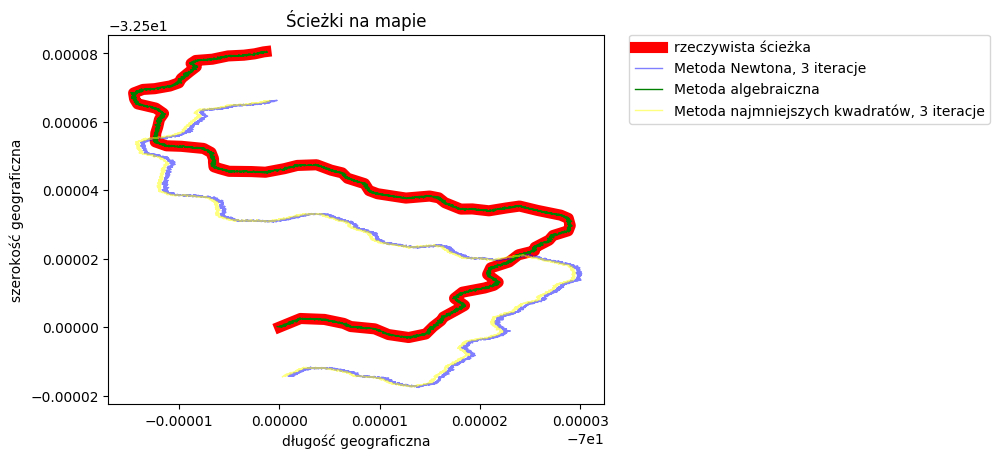

HTML{String}("<table border=\"1\">\n<tr><td><pre>Metoda</pre><td><pre>Największy błąd</pre><td><pre>Najmniejszy błąd</pre></tr><tr><td><pre>Newtona, 3 iteracje</pre><td><pre>1.637160165988826</pre><td><pre>1.5733112593081355</pre></tr><tr><td><pre>Najmnieszych kwadratów, 3 iteracje</pre><td><pre>1.631124190006484</pre><td><pre>1.5670569959531226</pre></tr><tr><td><pre>Algebraiczna</pre><td><pre>0.04473901887336132</pre><td><pre>0.0006479876044590793</pre></tr><tr><td><pre>Bancrofta</pre><td><pre>0.04049772577366741</pre><td><pre>0.0005212503564261917</pre></tr></table>")

In [104]:
coords = path(3000, -70, -32.5)
x = coords[1]
y = coords[2]

mistake = 0.005

newton_coords = GPS_newton(coords, mistake, 3, true)
xn = newton_coords[1]
yn = newton_coords[2]

leastSquares_coords = GPS_leastSquares(coords, mistake, 3, sat_count, true)
xl = leastSquares_coords[1]
yl = leastSquares_coords[2]

alg_coords = GPS_alg(coords, mistake, true)
xa = alg_coords[1]
ya = alg_coords[2]

bancroft_coords = GPS_bancroft(coords, mistake, true)
xb = bancroft_coords[1]
yb = bancroft_coords[2]

fig, ax = subplots()

title("Ścieżki na mapie")
xlabel("długość geograficzna")
ylabel("szerokość geograficzna")
ax[:plot](x, y, "-", color="red", linewidth=8, alpha=1.0, label="rzeczywista ścieżka")
ax[:plot](xn, yn, "-", color="blue", linewidth=1, alpha=0.5, label="Metoda Newtona, 3 iteracje")
ax[:plot](xa, ya, "-", color="green", linewidth=1, alpha=1.0, label="Metoda algebraiczna")
ax[:plot](xl, yl, "-", color="yellow", linewidth=1, alpha=0.5, label="Metoda najmniejszych kwadratów, 3 iteracje")
ax[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
show()

methods =["Newtona, 3 iteracje", "Najmnieszych kwadratów, 3 iteracje", "Algebraiczna", "Bancrofta"]
results = [newton_coords, leastSquares_coords, alg_coords, bancroft_coords]

MinMaxMistakeTable(methods, results, coords)


In [105]:
function clock_mistake_plot(method, coords, maxiter)
    res = [[], []]
    dm = 0.1
    mistake = 0.0
    for i in 1:maxiter
        alg_coords = method(coords, mistake)
        dist = MAXdist(coords, alg_coords)
        push!(res[1], mistake)
        push!(res[2], dist)
        mistake+=dm
    end
    res
end;

Istotnym czynnikiem wpływającym na niedokładność pomiaru jest błąd zegara.

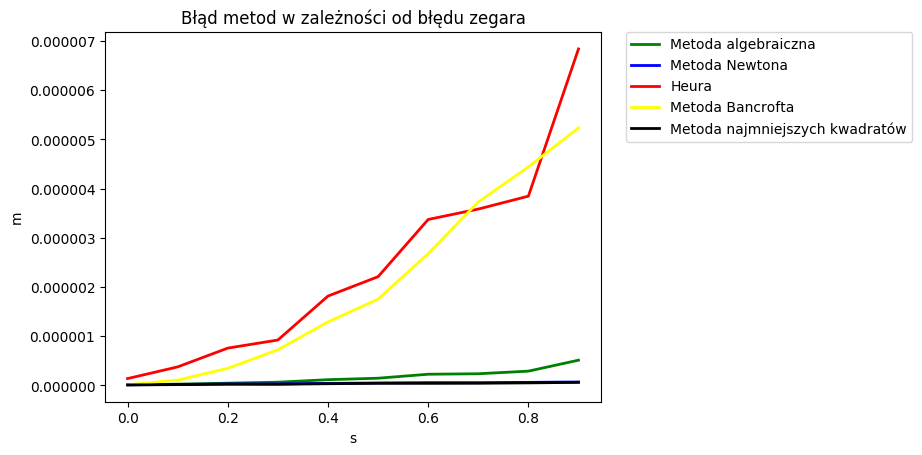

In [106]:
data1 = clock_mistake_plot(GPS_alg, coords, 10)
x = data1[1]
y1 = data1[2]

data2 = clock_mistake_plot(GPS_newton, coords, 10)
y2 = data2[2]

data3 = clock_mistake_plot(GPS_heura, coords, 10)
y3 = data3[2]

data4 = clock_mistake_plot(GPS_bancroft, coords, 10)
y4 = data4[2]

data5 = clock_mistake_plot(GPS_leastSquares, coords, 10)
y5 =  data5[2]

fig, ax = subplots()

title("Błąd metod w zależności od błędu zegara")
ylabel("m")
xlabel("s")
ax[:plot](x, y1, "-", color="green", linewidth=2, alpha=1.0, label="Metoda algebraiczna")
ax[:plot](x, y2, "-", color="blue", linewidth=2, alpha=1.0, label="Metoda Newtona")
ax[:plot](x, y3, "-", color="red", linewidth=2, alpha=1.0, label="Heura")
ax[:plot](x, y4, "-", color="yellow", linewidth=2, alpha=1.0, label="Metoda Bancrofta")
ax[:plot](x, y5, "-", color="black", linewidth=2, alpha=1.0, label="Metoda najmniejszych kwadratów")
ax[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

show()

W metodach Newtona oraz najmniejszych kwadratów dokładność powinna zwiększać się wraz z liczbą iteracji. Można udowodnić, że powinna to być zbieżność kwadratowa. 

In [107]:
function iter_mistake_plot(method, coords, maxiter)
    res = [[], []]
    for i in 1:maxiter
        newton_coords = method(coords, 0.005, i)
        dist = MAXdist(coords, newton_coords)
        push!(res[1], i)
        push!(res[2], dist)
    end
    return res
end
show()

In [108]:
data1 = iter_mistake_plot(GPS_newton, coords, 10)
x = data1[1]
y1 = data1[2]

data2 = iter_mistake_plot(GPS_leastSquares, coords, 10)
y2 = data2[2]

tab = hcat(x, y1, y2)

table(tab, column_names=[:"Iteracja", :"Błąd metody Newtona (m)", :"Błąd metody najmniejszych kwadratów (m)"])

HTML{String}("<table border=\"1\">\n<tr><td><pre>Iteracja</pre><td><pre>Błąd metody Newtona (m)</pre><td><pre>Błąd metody najmniejszych kwadratów (m)</pre></tr><tr><td><pre>1</pre><td><pre>172567.17946042828</pre><td><pre>172038.5126277926</pre></tr><tr><td><pre>2</pre><td><pre>3698.843083397237</pre><td><pre>3686.913833536747</pre></tr><tr><td><pre>3</pre><td><pre>1.6010072506780817</pre><td><pre>1.595356062872918</pre></tr><tr><td><pre>4</pre><td><pre>3.1078579789991315e-7</pre><td><pre>3.065901108778231e-7</pre></tr><tr><td><pre>5</pre><td><pre>1.0676882886285871e-8</pre><td><pre>9.052214062373596e-9</pre></tr><tr><td><pre>6</pre><td><pre>1.0282218731476872e-8</pre><td><pre>8.687935939880299e-9</pre></tr><tr><td><pre>7</pre><td><pre>1.0007025177703957e-8</pre><td><pre>8.879225874701039e-9</pre></tr><tr><td><pre>8</pre><td><pre>1.0259567873325503e-8</pre><td><pre>8.879225874701039e-9</pre></tr><tr><td><pre>9</pre><td><pre>9.774423806540962e-9</pre><td><pre>8.994920992723784e-9</pre></tr><tr><td><pre>10</pre><td><pre>9.840316583168897e-9</pre><td><pre>8.879225874701039e-9</pre></tr></table>")

Poniżej sprawdzamy dokładność pomiarów dla losowych punktów na Ziemi

In [109]:
sat_count = 10
sat = Array{Array{Float64}}(sat_count)

mean1 = 0
mean2 = 0
mean3 = 0
mean4 = 0
mean5 = 0

iters = 5000

for i = 1:iters
    sat = [ rand_position(sat_rad) for j = 1:sat_count ]
    x = rand_position(earth_rad)
    #LL = XYZtoLLA(x)
    #mistake = 0.00001
    #sat =  createSats(LL[1], LL[2], mistake)
    prepsat!(x, sat)
    x1 = newton(sat[1:4])
    x2 = algebraic(sat)
    x3 = bancroft(sat)
    x4 = heura(sat)
    x5 = leastSquares(sat)

    mean1 += sum(abs2, x1 - x)
    mean2 += sum(abs2, x2 - x)
    mean3 += sum(abs2, x3 - x)
    mean4 += sum(abs2, x4 - x)
    mean5 += sum(abs2, x5 - x)
end

mean1 /= iters
mean2 /= iters
mean3 /= iters
mean4 /= iters
mean5 /= iters

names = ["Newton", "Algebraiczna", "Bancroft", "Heura", "Najmniejszych kwadratów"]
results = [mean1, mean2, mean3, mean4, mean5]

table(hcat(names, results), column_names=[:Metoda, :"Średni błąd (m)"])

HTML{String}("<table border=\"1\">\n<tr><td><pre>Metoda</pre><td><pre>Średni błąd (m)</pre></tr><tr><td><pre>Newton</pre><td><pre>4.0329546489363596e7</pre></tr><tr><td><pre>Algebraiczna</pre><td><pre>7.9448199865497e-23</pre></tr><tr><td><pre>Bancroft</pre><td><pre>2.3451929659066707e-21</pre></tr><tr><td><pre>Heura</pre><td><pre>3.2801354524524757e-21</pre></tr><tr><td><pre>Najmniejszych kwadratów</pre><td><pre>2.5450386064484224e7</pre></tr></table>")

Wpływ liczby satelit na dokładność metody najmniejszych kwadratów

In [146]:
function leastSquares_sat_plot(positers=100, satiters=50)
    res = [[],[]]
    
    sat = [ rand_position(sat_rad) for i in 1:satiters ]
    means = zeros(satiters)

    for i in 1:positers
        x = rand_position(earth_rad)
        prepsat!(x, sat)
        for sat_cnt in 4:satiters
            xgps = leastSquares(sat, 10, sat_cnt)
            means[sat_cnt] += sum(abs2, xgps-x)
        end
    end
    for i in 4:satiters
        push!(res[1], i)
        push!(res[2], means[i]/positers)
    end
    res
end;

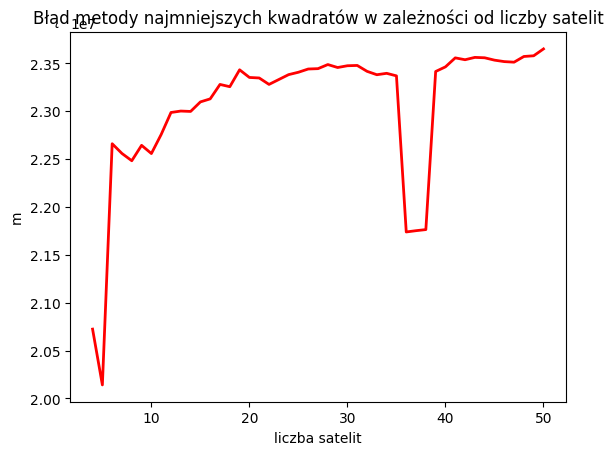

In [147]:
data = leastSquares_sat_plot()
x = data[1]
y = data[2]

fig, ax = subplots()

title("Błąd metody najmniejszych kwadratów w zależności od liczby satelit")
ylabel("m")
xlabel("liczba satelit")
ax[:plot](x, y, "-", color="red", linewidth=2, alpha=1.0)
show()